In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[26].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.71it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 13/2000 [00:00<01:06, 29.82it/s]

Epoch 10/2000, Loss: 0.4191
Test Accuracy at Epoch 10: 69.21%
Test F1-score at Epoch 10: 0.7260
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.56      0.65       194
non_infringement       0.64      0.83      0.73       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380

New best model saved with F1-score 0.7260 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.56      0.65       194
non_infringement       0.64      0.83      0.73       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   1%|          | 22/2000 [00:00<01:00, 32.69it/s]

Epoch 20/2000, Loss: 0.3212
Test Accuracy at Epoch 20: 70.26%
Test F1-score at Epoch 20: 0.7449
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.83      0.53      0.64       194
non_infringement       0.64      0.89      0.74       186

        accuracy                           0.70       380
       macro avg       0.74      0.71      0.69       380
    weighted avg       0.74      0.70      0.69       380

New best model saved with F1-score 0.7449 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.83      0.53      0.64       194
non_infringement       0.64      0.89      0.74       186

        accuracy                           0.70       380
       macro avg       0.74      0.71      0.69       380
    weighted avg       0.74      0.70      0.69       380



Training Epochs:   2%|▏         | 34/2000 [00:01<01:00, 32.74it/s]

Epoch 30/2000, Loss: 0.2694
Test Accuracy at Epoch 30: 77.37%
Test F1-score at Epoch 30: 0.7839
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.74      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380

New best model saved with F1-score 0.7839 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.74      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   2%|▏         | 46/2000 [00:01<00:57, 34.03it/s]

Epoch 40/2000, Loss: 0.2174
Test Accuracy at Epoch 40: 74.47%
Test F1-score at Epoch 40: 0.7760
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.86      0.59      0.70       194
non_infringement       0.68      0.90      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:   3%|▎         | 54/2000 [00:01<00:59, 32.59it/s]

Epoch 50/2000, Loss: 0.1704
Test Accuracy at Epoch 50: 73.95%
Test F1-score at Epoch 50: 0.7648
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       194
non_infringement       0.69      0.87      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:   3%|▎         | 63/2000 [00:01<00:54, 35.65it/s]

Epoch 60/2000, Loss: 0.1483
Test Accuracy at Epoch 60: 73.42%
Test F1-score at Epoch 60: 0.7506
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   4%|▍         | 76/2000 [00:02<00:54, 35.06it/s]

Epoch 70/2000, Loss: 0.1389
Test Accuracy at Epoch 70: 74.21%
Test F1-score at Epoch 70: 0.7500
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   4%|▍         | 85/2000 [00:02<00:56, 33.74it/s]

Epoch 80/2000, Loss: 0.1277
Test Accuracy at Epoch 80: 76.32%
Test F1-score at Epoch 80: 0.7644
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   5%|▍         | 94/2000 [00:02<00:59, 32.20it/s]

Epoch 90/2000, Loss: 0.1310
Test Accuracy at Epoch 90: 73.95%
Test F1-score at Epoch 90: 0.7494
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   5%|▌         | 103/2000 [00:03<00:53, 35.70it/s]

Epoch 100/2000, Loss: 0.1191
Test Accuracy at Epoch 100: 74.47%
Test F1-score at Epoch 100: 0.7506
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   6%|▌         | 116/2000 [00:03<00:53, 35.49it/s]

Epoch 110/2000, Loss: 0.1138
Test Accuracy at Epoch 110: 75.00%
Test F1-score at Epoch 110: 0.7570
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   6%|▋         | 125/2000 [00:03<00:54, 34.62it/s]

Epoch 120/2000, Loss: 0.1117
Test Accuracy at Epoch 120: 73.95%
Test F1-score at Epoch 120: 0.7519
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   7%|▋         | 133/2000 [00:04<01:01, 30.40it/s]

Epoch 130/2000, Loss: 0.1124
Test Accuracy at Epoch 130: 77.37%
Test F1-score at Epoch 130: 0.7688
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.78      0.78      0.78       194
non_infringement       0.77      0.77      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:   7%|▋         | 142/2000 [00:04<00:54, 34.12it/s]

Epoch 140/2000, Loss: 0.1069
Test Accuracy at Epoch 140: 76.32%
Test F1-score at Epoch 140: 0.7692
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   8%|▊         | 154/2000 [00:04<00:57, 32.28it/s]

Epoch 150/2000, Loss: 0.1073
Test Accuracy at Epoch 150: 76.32%
Test F1-score at Epoch 150: 0.7716
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   8%|▊         | 167/2000 [00:05<00:53, 34.22it/s]

Epoch 160/2000, Loss: 0.1046
Test Accuracy at Epoch 160: 74.47%
Test F1-score at Epoch 160: 0.7581
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   9%|▉         | 175/2000 [00:05<00:56, 32.48it/s]

Epoch 170/2000, Loss: 0.1038
Test Accuracy at Epoch 170: 76.32%
Test F1-score at Epoch 170: 0.7692
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   9%|▉         | 184/2000 [00:05<00:56, 32.27it/s]

Epoch 180/2000, Loss: 0.1029
Test Accuracy at Epoch 180: 73.95%
Test F1-score at Epoch 180: 0.7556
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       194
non_infringement       0.70      0.82      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  10%|▉         | 193/2000 [00:05<00:57, 31.63it/s]

Epoch 190/2000, Loss: 0.1063
Test Accuracy at Epoch 190: 78.95%
Test F1-score at Epoch 190: 0.7906
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380

New best model saved with F1-score 0.7906 at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



Training Epochs:  10%|█         | 206/2000 [00:06<00:52, 34.11it/s]

Epoch 200/2000, Loss: 0.1010
Test Accuracy at Epoch 200: 76.84%
Test F1-score at Epoch 200: 0.7766
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.82      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  11%|█         | 215/2000 [00:06<00:51, 34.74it/s]

Epoch 210/2000, Loss: 0.1005
Test Accuracy at Epoch 210: 75.79%
Test F1-score at Epoch 210: 0.7688
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  11%|█         | 224/2000 [00:06<00:55, 32.03it/s]

Epoch 220/2000, Loss: 0.1000
Test Accuracy at Epoch 220: 75.79%
Test F1-score at Epoch 220: 0.7665
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  12%|█▏        | 233/2000 [00:07<00:49, 35.80it/s]

Epoch 230/2000, Loss: 0.1040
Test Accuracy at Epoch 230: 77.37%
Test F1-score at Epoch 230: 0.7676
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.78      0.78      0.78       194
non_infringement       0.77      0.76      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  12%|█▏        | 246/2000 [00:07<00:46, 37.57it/s]

Epoch 240/2000, Loss: 0.1030
Test Accuracy at Epoch 240: 75.79%
Test F1-score at Epoch 240: 0.7641
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  13%|█▎        | 254/2000 [00:07<00:51, 33.68it/s]

Epoch 250/2000, Loss: 0.1014
Test Accuracy at Epoch 250: 77.63%
Test F1-score at Epoch 250: 0.7721
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.78      0.78      0.78       194
non_infringement       0.77      0.77      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  13%|█▎        | 263/2000 [00:07<00:47, 36.55it/s]

Epoch 260/2000, Loss: 0.0983
Test Accuracy at Epoch 260: 75.26%
Test F1-score at Epoch 260: 0.7626
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  14%|█▍        | 276/2000 [00:08<00:45, 37.95it/s]

Epoch 270/2000, Loss: 0.0986
Test Accuracy at Epoch 270: 76.05%
Test F1-score at Epoch 270: 0.7661
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.80      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  14%|█▍        | 285/2000 [00:08<00:47, 36.22it/s]

Epoch 280/2000, Loss: 0.0980
Test Accuracy at Epoch 280: 76.58%
Test F1-score at Epoch 280: 0.7700
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  15%|█▍        | 295/2000 [00:08<00:48, 34.99it/s]

Epoch 290/2000, Loss: 0.0972
Test Accuracy at Epoch 290: 75.53%
Test F1-score at Epoch 290: 0.7621
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  15%|█▌        | 305/2000 [00:09<00:44, 38.26it/s]

Epoch 300/2000, Loss: 0.0968
Test Accuracy at Epoch 300: 76.58%
Test F1-score at Epoch 300: 0.7700
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  16%|█▌        | 313/2000 [00:09<00:52, 32.16it/s]

Epoch 310/2000, Loss: 0.0963
Test Accuracy at Epoch 310: 75.79%
Test F1-score at Epoch 310: 0.7641
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  16%|█▌        | 322/2000 [00:09<00:59, 28.09it/s]

Epoch 320/2000, Loss: 0.0971
Test Accuracy at Epoch 320: 78.42%
Test F1-score at Epoch 320: 0.7842
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.80      0.77      0.78       194
non_infringement       0.77      0.80      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  17%|█▋        | 331/2000 [00:09<00:51, 32.53it/s]

Epoch 330/2000, Loss: 0.1093
Test Accuracy at Epoch 330: 73.95%
Test F1-score at Epoch 330: 0.7506
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  17%|█▋        | 345/2000 [00:10<00:46, 35.56it/s]

Epoch 340/2000, Loss: 0.0990
Test Accuracy at Epoch 340: 77.63%
Test F1-score at Epoch 340: 0.7745
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.79      0.77      0.78       194
non_infringement       0.76      0.78      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  18%|█▊        | 353/2000 [00:10<00:48, 33.77it/s]

Epoch 350/2000, Loss: 0.0974
Test Accuracy at Epoch 350: 76.32%
Test F1-score at Epoch 350: 0.7680
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  18%|█▊        | 366/2000 [00:10<00:49, 33.06it/s]

Epoch 360/2000, Loss: 0.0961
Test Accuracy at Epoch 360: 75.53%
Test F1-score at Epoch 360: 0.7621
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  18%|█▊        | 370/2000 [00:11<00:47, 34.15it/s]

Epoch 370/2000, Loss: 0.0956
Test Accuracy at Epoch 370: 76.58%
Test F1-score at Epoch 370: 0.7700
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  19%|█▉        | 384/2000 [00:11<00:44, 36.69it/s]

Epoch 380/2000, Loss: 0.0952
Test Accuracy at Epoch 380: 75.79%
Test F1-score at Epoch 380: 0.7641
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  20%|█▉        | 398/2000 [00:11<00:40, 39.53it/s]

Epoch 390/2000, Loss: 0.0949
Test Accuracy at Epoch 390: 76.58%
Test F1-score at Epoch 390: 0.7700
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  20%|██        | 403/2000 [00:11<00:43, 36.65it/s]

Epoch 400/2000, Loss: 0.0947
Test Accuracy at Epoch 400: 76.58%
Test F1-score at Epoch 400: 0.7700
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  21%|██        | 419/2000 [00:12<00:35, 44.77it/s]

Epoch 410/2000, Loss: 0.0945
Test Accuracy at Epoch 410: 76.58%
Test F1-score at Epoch 410: 0.7700
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  21%|██        | 424/2000 [00:12<00:40, 38.64it/s]

Epoch 420/2000, Loss: 0.0944
Test Accuracy at Epoch 420: 76.58%
Test F1-score at Epoch 420: 0.7700
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  22%|██▏       | 434/2000 [00:12<00:37, 41.86it/s]

Epoch 430/2000, Loss: 0.0942
Test Accuracy at Epoch 430: 76.58%
Test F1-score at Epoch 430: 0.7700
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  22%|██▏       | 449/2000 [00:13<00:36, 42.32it/s]

Epoch 440/2000, Loss: 0.0943
Test Accuracy at Epoch 440: 76.32%
Test F1-score at Epoch 440: 0.7668
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  23%|██▎       | 454/2000 [00:13<00:40, 38.00it/s]

Epoch 450/2000, Loss: 0.1097
Test Accuracy at Epoch 450: 74.74%
Test F1-score at Epoch 450: 0.7659
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.73       194
non_infringement       0.70      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  23%|██▎       | 464/2000 [00:13<00:37, 41.51it/s]

Epoch 460/2000, Loss: 0.1010
Test Accuracy at Epoch 460: 75.53%
Test F1-score at Epoch 460: 0.7609
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  24%|██▎       | 474/2000 [00:13<00:38, 40.10it/s]

Epoch 470/2000, Loss: 0.0969
Test Accuracy at Epoch 470: 76.05%
Test F1-score at Epoch 470: 0.7649
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.79      0.73      0.76       194
non_infringement       0.74      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  24%|██▍       | 485/2000 [00:14<00:40, 37.62it/s]

Epoch 480/2000, Loss: 0.0951
Test Accuracy at Epoch 480: 76.84%
Test F1-score at Epoch 480: 0.7778
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  25%|██▍       | 496/2000 [00:14<00:35, 42.49it/s]

Epoch 490/2000, Loss: 0.0944
Test Accuracy at Epoch 490: 77.37%
Test F1-score at Epoch 490: 0.7817
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  25%|██▌       | 506/2000 [00:14<00:37, 40.05it/s]

Epoch 500/2000, Loss: 0.0941
Test Accuracy at Epoch 500: 77.63%
Test F1-score at Epoch 500: 0.7837
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  26%|██▌       | 516/2000 [00:14<00:38, 38.14it/s]

Epoch 510/2000, Loss: 0.0939
Test Accuracy at Epoch 510: 77.37%
Test F1-score at Epoch 510: 0.7817
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  26%|██▋       | 527/2000 [00:15<00:34, 42.82it/s]

Epoch 520/2000, Loss: 0.0938
Test Accuracy at Epoch 520: 77.63%
Test F1-score at Epoch 520: 0.7837
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  27%|██▋       | 532/2000 [00:15<00:38, 38.26it/s]

Epoch 530/2000, Loss: 0.0937
Test Accuracy at Epoch 530: 77.11%
Test F1-score at Epoch 530: 0.7797
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  27%|██▋       | 547/2000 [00:15<00:33, 43.78it/s]

Epoch 540/2000, Loss: 0.0936
Test Accuracy at Epoch 540: 77.63%
Test F1-score at Epoch 540: 0.7837
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  28%|██▊       | 557/2000 [00:15<00:34, 41.26it/s]

Epoch 550/2000, Loss: 0.0935
Test Accuracy at Epoch 550: 77.37%
Test F1-score at Epoch 550: 0.7817
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  28%|██▊       | 562/2000 [00:15<00:34, 41.91it/s]

Epoch 560/2000, Loss: 0.0934
Test Accuracy at Epoch 560: 77.63%
Test F1-score at Epoch 560: 0.7837
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  29%|██▉       | 578/2000 [00:16<00:33, 42.45it/s]

Epoch 570/2000, Loss: 0.0933
Test Accuracy at Epoch 570: 77.63%
Test F1-score at Epoch 570: 0.7837
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  29%|██▉       | 588/2000 [00:16<00:35, 39.85it/s]

Epoch 580/2000, Loss: 0.0933
Test Accuracy at Epoch 580: 77.63%
Test F1-score at Epoch 580: 0.7837
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  30%|██▉       | 593/2000 [00:16<00:35, 39.24it/s]

Epoch 590/2000, Loss: 0.0932
Test Accuracy at Epoch 590: 77.63%
Test F1-score at Epoch 590: 0.7837
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  30%|███       | 609/2000 [00:17<00:31, 43.62it/s]

Epoch 600/2000, Loss: 0.0931
Test Accuracy at Epoch 600: 77.63%
Test F1-score at Epoch 600: 0.7837
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  31%|███       | 614/2000 [00:17<00:35, 39.13it/s]

Epoch 610/2000, Loss: 0.0931
Test Accuracy at Epoch 610: 76.84%
Test F1-score at Epoch 610: 0.7778
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  31%|███       | 624/2000 [00:17<00:32, 42.27it/s]

Epoch 620/2000, Loss: 0.0941
Test Accuracy at Epoch 620: 75.00%
Test F1-score at Epoch 620: 0.7643
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.80      0.68      0.73       194
non_infringement       0.71      0.83      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  32%|███▏      | 639/2000 [00:17<00:32, 42.09it/s]

Epoch 630/2000, Loss: 0.1023
Test Accuracy at Epoch 630: 77.11%
Test F1-score at Epoch 630: 0.7797
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  32%|███▏      | 644/2000 [00:17<00:36, 36.92it/s]

Epoch 640/2000, Loss: 0.0964
Test Accuracy at Epoch 640: 76.84%
Test F1-score at Epoch 640: 0.7778
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  33%|███▎      | 654/2000 [00:18<00:33, 40.67it/s]

Epoch 650/2000, Loss: 0.0948
Test Accuracy at Epoch 650: 77.11%
Test F1-score at Epoch 650: 0.7797
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  33%|███▎      | 665/2000 [00:18<00:32, 40.78it/s]

Epoch 660/2000, Loss: 0.0956
Test Accuracy at Epoch 660: 76.84%
Test F1-score at Epoch 660: 0.7778
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  34%|███▍      | 676/2000 [00:18<00:29, 44.85it/s]

Epoch 670/2000, Loss: 0.0946
Test Accuracy at Epoch 670: 77.63%
Test F1-score at Epoch 670: 0.7837
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  34%|███▍      | 687/2000 [00:19<00:31, 42.22it/s]

Epoch 680/2000, Loss: 0.0964
Test Accuracy at Epoch 680: 77.37%
Test F1-score at Epoch 680: 0.7817
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  35%|███▍      | 692/2000 [00:19<00:29, 43.62it/s]

Epoch 690/2000, Loss: 0.0950
Test Accuracy at Epoch 690: 77.11%
Test F1-score at Epoch 690: 0.7797
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  35%|███▌      | 708/2000 [00:19<00:28, 44.65it/s]

Epoch 700/2000, Loss: 0.0935
Test Accuracy at Epoch 700: 77.11%
Test F1-score at Epoch 700: 0.7797
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  36%|███▌      | 713/2000 [00:19<00:32, 39.44it/s]

Epoch 710/2000, Loss: 0.0934
Test Accuracy at Epoch 710: 77.11%
Test F1-score at Epoch 710: 0.7797
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  36%|███▌      | 723/2000 [00:19<00:30, 41.90it/s]

Epoch 720/2000, Loss: 0.0932
Test Accuracy at Epoch 720: 77.63%
Test F1-score at Epoch 720: 0.7837
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  37%|███▋      | 738/2000 [00:20<00:30, 41.63it/s]

Epoch 730/2000, Loss: 0.0930
Test Accuracy at Epoch 730: 76.32%
Test F1-score at Epoch 730: 0.7739
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  37%|███▋      | 743/2000 [00:20<00:34, 36.96it/s]

Epoch 740/2000, Loss: 0.0930
Test Accuracy at Epoch 740: 76.84%
Test F1-score at Epoch 740: 0.7778
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  38%|███▊      | 754/2000 [00:20<00:29, 41.85it/s]

Epoch 750/2000, Loss: 0.0929
Test Accuracy at Epoch 750: 77.11%
Test F1-score at Epoch 750: 0.7797
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  38%|███▊      | 764/2000 [00:20<00:30, 39.98it/s]

Epoch 760/2000, Loss: 0.0929
Test Accuracy at Epoch 760: 77.11%
Test F1-score at Epoch 760: 0.7797
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  39%|███▉      | 775/2000 [00:21<00:31, 39.21it/s]

Epoch 770/2000, Loss: 0.0928
Test Accuracy at Epoch 770: 76.84%
Test F1-score at Epoch 770: 0.7778
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  39%|███▉      | 785/2000 [00:21<00:28, 42.12it/s]

Epoch 780/2000, Loss: 0.0928
Test Accuracy at Epoch 780: 77.11%
Test F1-score at Epoch 780: 0.7797
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  40%|███▉      | 795/2000 [00:21<00:29, 40.17it/s]

Epoch 790/2000, Loss: 0.0927
Test Accuracy at Epoch 790: 77.11%
Test F1-score at Epoch 790: 0.7797
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  40%|████      | 805/2000 [00:21<00:27, 42.81it/s]

Epoch 800/2000, Loss: 0.0927
Test Accuracy at Epoch 800: 77.11%
Test F1-score at Epoch 800: 0.7797
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  41%|████      | 815/2000 [00:22<00:29, 40.49it/s]

Epoch 810/2000, Loss: 0.0927
Test Accuracy at Epoch 810: 77.11%
Test F1-score at Epoch 810: 0.7797
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  41%|████▏     | 825/2000 [00:22<00:31, 37.39it/s]

Epoch 820/2000, Loss: 0.0927
Test Accuracy at Epoch 820: 77.11%
Test F1-score at Epoch 820: 0.7797
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  42%|████▏     | 836/2000 [00:22<00:27, 42.54it/s]

Epoch 830/2000, Loss: 0.0926
Test Accuracy at Epoch 830: 76.84%
Test F1-score at Epoch 830: 0.7778
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  42%|████▏     | 847/2000 [00:22<00:26, 43.15it/s]

Epoch 840/2000, Loss: 0.0926
Test Accuracy at Epoch 840: 76.05%
Test F1-score at Epoch 840: 0.7719
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 850/2000, Loss: 0.0929


Training Epochs:  43%|████▎     | 857/2000 [00:23<00:27, 40.92it/s]

Test Accuracy at Epoch 850: 76.05%
Test F1-score at Epoch 850: 0.7719
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  43%|████▎     | 868/2000 [00:23<00:25, 44.45it/s]

Epoch 860/2000, Loss: 0.0986
Test Accuracy at Epoch 860: 78.42%
Test F1-score at Epoch 860: 0.7865
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.81      0.76      0.78       194
non_infringement       0.76      0.81      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  44%|████▎     | 873/2000 [00:23<00:27, 40.75it/s]

Epoch 870/2000, Loss: 0.0941
Test Accuracy at Epoch 870: 76.32%
Test F1-score at Epoch 870: 0.7739
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  44%|████▍     | 884/2000 [00:23<00:25, 43.75it/s]

Epoch 880/2000, Loss: 0.0934
Test Accuracy at Epoch 880: 77.11%
Test F1-score at Epoch 880: 0.7797
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  45%|████▍     | 895/2000 [00:24<00:26, 41.48it/s]

Epoch 890/2000, Loss: 0.0929
Test Accuracy at Epoch 890: 76.32%
Test F1-score at Epoch 890: 0.7739
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  45%|████▌     | 906/2000 [00:24<00:28, 38.64it/s]

Epoch 900/2000, Loss: 0.0927
Test Accuracy at Epoch 900: 77.11%
Test F1-score at Epoch 900: 0.7797
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  46%|████▌     | 917/2000 [00:24<00:24, 43.55it/s]

Epoch 910/2000, Loss: 0.0927
Test Accuracy at Epoch 910: 76.32%
Test F1-score at Epoch 910: 0.7739
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  46%|████▌     | 922/2000 [00:24<00:24, 43.19it/s]

Epoch 920/2000, Loss: 0.0926
Test Accuracy at Epoch 920: 77.11%
Test F1-score at Epoch 920: 0.7797
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  47%|████▋     | 938/2000 [00:25<00:23, 45.34it/s]

Epoch 930/2000, Loss: 0.0926
Test Accuracy at Epoch 930: 76.32%
Test F1-score at Epoch 930: 0.7739
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  47%|████▋     | 949/2000 [00:25<00:24, 42.22it/s]

Epoch 940/2000, Loss: 0.0925
Test Accuracy at Epoch 940: 76.32%
Test F1-score at Epoch 940: 0.7739
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  48%|████▊     | 954/2000 [00:25<00:24, 42.93it/s]

Epoch 950/2000, Loss: 0.0925
Test Accuracy at Epoch 950: 77.11%
Test F1-score at Epoch 950: 0.7797
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  48%|████▊     | 964/2000 [00:25<00:24, 41.97it/s]

Epoch 960/2000, Loss: 0.0925
Test Accuracy at Epoch 960: 77.11%
Test F1-score at Epoch 960: 0.7797
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 970/2000, Loss: 0.0925


Training Epochs:  49%|████▉     | 975/2000 [00:26<00:24, 41.26it/s]

Test Accuracy at Epoch 970: 77.11%
Test F1-score at Epoch 970: 0.7797
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  49%|████▉     | 986/2000 [00:26<00:22, 45.36it/s]

Epoch 980/2000, Loss: 0.0925
Test Accuracy at Epoch 980: 76.58%
Test F1-score at Epoch 980: 0.7758
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  50%|████▉     | 996/2000 [00:26<00:23, 42.36it/s]

Epoch 990/2000, Loss: 0.0924
Test Accuracy at Epoch 990: 76.58%
Test F1-score at Epoch 990: 0.7758
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  50%|█████     | 1001/2000 [00:26<00:23, 42.10it/s]

Epoch 1000/2000, Loss: 0.0924
Test Accuracy at Epoch 1000: 76.84%
Test F1-score at Epoch 1000: 0.7778
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  51%|█████     | 1016/2000 [00:27<00:28, 34.73it/s]

Epoch 1010/2000, Loss: 0.0924
Test Accuracy at Epoch 1010: 76.84%
Test F1-score at Epoch 1010: 0.7778
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  51%|█████▏    | 1026/2000 [00:27<00:27, 35.15it/s]

Epoch 1020/2000, Loss: 0.0924
Test Accuracy at Epoch 1020: 76.84%
Test F1-score at Epoch 1020: 0.7778
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1030/2000, Loss: 0.0927
Test Accuracy at Epoch 1030: 77.11%
Test F1-score at Epoch 1030: 0.7797


Training Epochs:  52%|█████▏    | 1037/2000 [00:27<00:24, 39.29it/s]

Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  52%|█████▏    | 1049/2000 [00:27<00:20, 46.05it/s]

Epoch 1040/2000, Loss: 0.0931
Test Accuracy at Epoch 1040: 74.47%
Test F1-score at Epoch 1040: 0.7605
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  53%|█████▎    | 1054/2000 [00:28<00:22, 41.24it/s]

Epoch 1050/2000, Loss: 0.0953
Test Accuracy at Epoch 1050: 74.21%
Test F1-score at Epoch 1050: 0.7586
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  53%|█████▎    | 1065/2000 [00:28<00:21, 43.32it/s]

Epoch 1060/2000, Loss: 0.0996
Test Accuracy at Epoch 1060: 78.95%
Test F1-score at Epoch 1060: 0.7906
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



Training Epochs:  54%|█████▍    | 1076/2000 [00:28<00:21, 42.89it/s]

Epoch 1070/2000, Loss: 0.0942
Test Accuracy at Epoch 1070: 77.63%
Test F1-score at Epoch 1070: 0.7837
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380

Epoch 1080/2000, Loss: 0.0940


Training Epochs:  54%|█████▍    | 1086/2000 [00:28<00:22, 40.77it/s]

Test Accuracy at Epoch 1080: 77.63%
Test F1-score at Epoch 1080: 0.7837
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  55%|█████▍    | 1097/2000 [00:29<00:19, 46.17it/s]

Epoch 1090/2000, Loss: 0.0939
Test Accuracy at Epoch 1090: 77.63%
Test F1-score at Epoch 1090: 0.7837
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.82      0.73      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380

Epoch 1100/2000, Loss: 0.0959


Training Epochs:  55%|█████▌    | 1102/2000 [00:29<00:21, 40.89it/s]

Test Accuracy at Epoch 1100: 77.37%
Test F1-score at Epoch 1100: 0.7817
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.77       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  56%|█████▌    | 1113/2000 [00:29<00:20, 44.04it/s]

Epoch 1110/2000, Loss: 0.0935
Test Accuracy at Epoch 1110: 76.58%
Test F1-score at Epoch 1110: 0.7747
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  56%|█████▋    | 1129/2000 [00:29<00:19, 43.95it/s]

Epoch 1120/2000, Loss: 0.0929
Test Accuracy at Epoch 1120: 77.11%
Test F1-score at Epoch 1120: 0.7820
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  57%|█████▋    | 1134/2000 [00:29<00:22, 38.56it/s]

Epoch 1130/2000, Loss: 0.0927
Test Accuracy at Epoch 1130: 77.11%
Test F1-score at Epoch 1130: 0.7820
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  57%|█████▋    | 1146/2000 [00:30<00:19, 44.60it/s]

Epoch 1140/2000, Loss: 0.0926
Test Accuracy at Epoch 1140: 76.84%
Test F1-score at Epoch 1140: 0.7778
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1150/2000, Loss: 0.0925
Test Accuracy at Epoch 1150: 77.11%
Test F1-score at Epoch 1150: 0.7797


Training Epochs:  58%|█████▊    | 1157/2000 [00:30<00:19, 43.53it/s]

Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  58%|█████▊    | 1168/2000 [00:30<00:17, 47.92it/s]

Epoch 1160/2000, Loss: 0.0925
Test Accuracy at Epoch 1160: 76.84%
Test F1-score at Epoch 1160: 0.7778
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  59%|█████▉    | 1179/2000 [00:30<00:17, 46.61it/s]

Epoch 1170/2000, Loss: 0.0925
Test Accuracy at Epoch 1170: 76.84%
Test F1-score at Epoch 1170: 0.7778
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1180/2000, Loss: 0.0924


Training Epochs:  59%|█████▉    | 1184/2000 [00:31<00:17, 46.91it/s]

Test Accuracy at Epoch 1180: 76.84%
Test F1-score at Epoch 1180: 0.7778
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  60%|█████▉    | 1194/2000 [00:31<00:18, 44.04it/s]

Epoch 1190/2000, Loss: 0.0924
Test Accuracy at Epoch 1190: 77.11%
Test F1-score at Epoch 1190: 0.7797
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1200/2000, Loss: 0.0924
Test Accuracy at Epoch 1200: 77.11%
Test F1-score at Epoch 1200: 0.7797


Training Epochs:  60%|██████    | 1206/2000 [00:31<00:17, 44.23it/s]

Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  61%|██████    | 1218/2000 [00:31<00:15, 49.90it/s]

Epoch 1210/2000, Loss: 0.0924
Test Accuracy at Epoch 1210: 77.11%
Test F1-score at Epoch 1210: 0.7797
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1220/2000, Loss: 0.0924
Test Accuracy at Epoch 1220: 77.11%
Test F1-score at Epoch 1220: 0.7797
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  62%|██████▏   | 1236/2000 [00:32<00:16, 47.12it/s]

Epoch 1230/2000, Loss: 0.0924
Test Accuracy at Epoch 1230: 77.11%
Test F1-score at Epoch 1230: 0.7797
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1240/2000, Loss: 0.0923


Training Epochs:  62%|██████▏   | 1246/2000 [00:32<00:18, 40.87it/s]

Test Accuracy at Epoch 1240: 77.11%
Test F1-score at Epoch 1240: 0.7797
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  63%|██████▎   | 1257/2000 [00:32<00:16, 46.40it/s]

Epoch 1250/2000, Loss: 0.0923
Test Accuracy at Epoch 1250: 77.11%
Test F1-score at Epoch 1250: 0.7797
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  63%|██████▎   | 1268/2000 [00:32<00:16, 44.47it/s]

Epoch 1260/2000, Loss: 0.0923
Test Accuracy at Epoch 1260: 77.11%
Test F1-score at Epoch 1260: 0.7797
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1270/2000, Loss: 0.0923


Training Epochs:  64%|██████▍   | 1278/2000 [00:33<00:16, 42.58it/s]

Test Accuracy at Epoch 1270: 76.84%
Test F1-score at Epoch 1270: 0.7778
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  64%|██████▍   | 1289/2000 [00:33<00:15, 46.73it/s]

Epoch 1280/2000, Loss: 0.0923
Test Accuracy at Epoch 1280: 76.84%
Test F1-score at Epoch 1280: 0.7778
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1290/2000, Loss: 0.0923


Training Epochs:  65%|██████▍   | 1294/2000 [00:33<00:15, 46.30it/s]

Test Accuracy at Epoch 1290: 76.84%
Test F1-score at Epoch 1290: 0.7778
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  65%|██████▌   | 1304/2000 [00:33<00:16, 42.27it/s]

Epoch 1300/2000, Loss: 0.0923
Test Accuracy at Epoch 1300: 76.84%
Test F1-score at Epoch 1300: 0.7778
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  66%|██████▌   | 1315/2000 [00:34<00:17, 39.48it/s]

Epoch 1310/2000, Loss: 0.0923
Test Accuracy at Epoch 1310: 76.84%
Test F1-score at Epoch 1310: 0.7778
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  66%|██████▋   | 1326/2000 [00:34<00:15, 44.80it/s]

Epoch 1320/2000, Loss: 0.0923
Test Accuracy at Epoch 1320: 76.84%
Test F1-score at Epoch 1320: 0.7778
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  67%|██████▋   | 1337/2000 [00:34<00:15, 43.65it/s]

Epoch 1330/2000, Loss: 0.0923
Test Accuracy at Epoch 1330: 76.84%
Test F1-score at Epoch 1330: 0.7778
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1340/2000, Loss: 0.0923


Training Epochs:  67%|██████▋   | 1347/2000 [00:34<00:16, 40.70it/s]

Test Accuracy at Epoch 1340: 76.84%
Test F1-score at Epoch 1340: 0.7778
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  68%|██████▊   | 1358/2000 [00:35<00:13, 45.98it/s]

Epoch 1350/2000, Loss: 0.0923
Test Accuracy at Epoch 1350: 76.05%
Test F1-score at Epoch 1350: 0.7719
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1360/2000, Loss: 0.0968


Training Epochs:  68%|██████▊   | 1363/2000 [00:35<00:15, 41.32it/s]

Test Accuracy at Epoch 1360: 76.05%
Test F1-score at Epoch 1360: 0.7719
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  69%|██████▊   | 1374/2000 [00:35<00:13, 44.73it/s]

Epoch 1370/2000, Loss: 0.0931
Test Accuracy at Epoch 1370: 76.58%
Test F1-score at Epoch 1370: 0.7724
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1380/2000, Loss: 0.0931


Training Epochs:  69%|██████▉   | 1385/2000 [00:35<00:14, 43.55it/s]

Test Accuracy at Epoch 1380: 76.05%
Test F1-score at Epoch 1380: 0.7719
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  70%|██████▉   | 1396/2000 [00:35<00:13, 43.92it/s]

Epoch 1390/2000, Loss: 0.0926
Test Accuracy at Epoch 1390: 76.32%
Test F1-score at Epoch 1390: 0.7739
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  70%|███████   | 1407/2000 [00:36<00:14, 42.23it/s]

Epoch 1400/2000, Loss: 0.0924
Test Accuracy at Epoch 1400: 77.11%
Test F1-score at Epoch 1400: 0.7797
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  71%|███████   | 1417/2000 [00:36<00:14, 40.14it/s]

Epoch 1410/2000, Loss: 0.0923
Test Accuracy at Epoch 1410: 76.32%
Test F1-score at Epoch 1410: 0.7739
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  71%|███████▏  | 1428/2000 [00:36<00:12, 45.17it/s]

Epoch 1420/2000, Loss: 0.0923
Test Accuracy at Epoch 1420: 76.84%
Test F1-score at Epoch 1420: 0.7778
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1430/2000, Loss: 0.0923


Training Epochs:  72%|███████▏  | 1433/2000 [00:36<00:13, 40.91it/s]

Test Accuracy at Epoch 1430: 77.11%
Test F1-score at Epoch 1430: 0.7797
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  72%|███████▏  | 1444/2000 [00:37<00:12, 44.73it/s]

Epoch 1440/2000, Loss: 0.0923
Test Accuracy at Epoch 1440: 76.84%
Test F1-score at Epoch 1440: 0.7778
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  73%|███████▎  | 1454/2000 [00:37<00:12, 43.09it/s]

Epoch 1450/2000, Loss: 0.0923
Test Accuracy at Epoch 1450: 77.11%
Test F1-score at Epoch 1450: 0.7797
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  73%|███████▎  | 1466/2000 [00:37<00:12, 41.55it/s]

Epoch 1460/2000, Loss: 0.0923
Test Accuracy at Epoch 1460: 76.84%
Test F1-score at Epoch 1460: 0.7778
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  74%|███████▍  | 1477/2000 [00:37<00:11, 44.59it/s]

Epoch 1470/2000, Loss: 0.0922
Test Accuracy at Epoch 1470: 76.58%
Test F1-score at Epoch 1470: 0.7758
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  74%|███████▍  | 1482/2000 [00:37<00:13, 39.62it/s]

Epoch 1480/2000, Loss: 0.0922
Test Accuracy at Epoch 1480: 76.84%
Test F1-score at Epoch 1480: 0.7778
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  75%|███████▍  | 1498/2000 [00:38<00:11, 45.61it/s]

Epoch 1490/2000, Loss: 0.0922
Test Accuracy at Epoch 1490: 76.84%
Test F1-score at Epoch 1490: 0.7778
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  75%|███████▌  | 1509/2000 [00:38<00:10, 44.84it/s]

Epoch 1500/2000, Loss: 0.0922
Test Accuracy at Epoch 1500: 76.84%
Test F1-score at Epoch 1500: 0.7778
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1510/2000, Loss: 0.0922


Training Epochs:  76%|███████▌  | 1514/2000 [00:38<00:10, 45.16it/s]

Test Accuracy at Epoch 1510: 76.84%
Test F1-score at Epoch 1510: 0.7778
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  76%|███████▌  | 1524/2000 [00:38<00:11, 42.39it/s]

Epoch 1520/2000, Loss: 0.0922
Test Accuracy at Epoch 1520: 76.84%
Test F1-score at Epoch 1520: 0.7778
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  77%|███████▋  | 1535/2000 [00:39<00:11, 39.88it/s]

Epoch 1530/2000, Loss: 0.0922
Test Accuracy at Epoch 1530: 76.84%
Test F1-score at Epoch 1530: 0.7778
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  77%|███████▋  | 1546/2000 [00:39<00:10, 44.30it/s]

Epoch 1540/2000, Loss: 0.0922
Test Accuracy at Epoch 1540: 76.84%
Test F1-score at Epoch 1540: 0.7778
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  78%|███████▊  | 1557/2000 [00:39<00:10, 43.18it/s]

Epoch 1550/2000, Loss: 0.0922
Test Accuracy at Epoch 1550: 76.84%
Test F1-score at Epoch 1550: 0.7778
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  78%|███████▊  | 1562/2000 [00:39<00:10, 43.71it/s]

Epoch 1560/2000, Loss: 0.0922
Test Accuracy at Epoch 1560: 76.84%
Test F1-score at Epoch 1560: 0.7778
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  79%|███████▉  | 1579/2000 [00:40<00:09, 43.54it/s]

Epoch 1570/2000, Loss: 0.0922
Test Accuracy at Epoch 1570: 76.84%
Test F1-score at Epoch 1570: 0.7778
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  79%|███████▉  | 1584/2000 [00:40<00:10, 38.16it/s]

Epoch 1580/2000, Loss: 0.0922
Test Accuracy at Epoch 1580: 76.58%
Test F1-score at Epoch 1580: 0.7758
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  80%|███████▉  | 1594/2000 [00:40<00:09, 41.66it/s]

Epoch 1590/2000, Loss: 0.0922
Test Accuracy at Epoch 1590: 76.05%
Test F1-score at Epoch 1590: 0.7719
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  80%|████████  | 1605/2000 [00:40<00:09, 40.80it/s]

Epoch 1600/2000, Loss: 0.0979
Test Accuracy at Epoch 1600: 74.74%
Test F1-score at Epoch 1600: 0.7635
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  81%|████████  | 1616/2000 [00:41<00:08, 46.85it/s]

Epoch 1610/2000, Loss: 0.0950
Test Accuracy at Epoch 1610: 76.05%
Test F1-score at Epoch 1610: 0.7719
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  81%|████████▏ | 1627/2000 [00:41<00:08, 45.66it/s]

Epoch 1620/2000, Loss: 0.0932
Test Accuracy at Epoch 1620: 77.37%
Test F1-score at Epoch 1620: 0.7828
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.82      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1630/2000, Loss: 0.0925
Test Accuracy at Epoch 1630: 77.11%
Test F1-score at Epoch 1630: 0.7797


Training Epochs:  82%|████████▏ | 1637/2000 [00:41<00:08, 43.45it/s]

Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  82%|████████▏ | 1648/2000 [00:41<00:07, 48.39it/s]

Epoch 1640/2000, Loss: 0.0928
Test Accuracy at Epoch 1640: 76.05%
Test F1-score at Epoch 1640: 0.7719
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1650/2000, Loss: 0.0923
Test Accuracy at Epoch 1650: 76.84%
Test F1-score at Epoch 1650: 0.7778
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  83%|████████▎ | 1669/2000 [00:42<00:06, 48.32it/s]

Epoch 1660/2000, Loss: 0.0929
Test Accuracy at Epoch 1660: 76.32%
Test F1-score at Epoch 1660: 0.7750
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1670/2000, Loss: 0.0924
Test Accuracy at Epoch 1670: 77.11%
Test F1-score at Epoch 1670: 0.7797


Training Epochs:  84%|████████▎ | 1674/2000 [00:42<00:07, 41.63it/s]

Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  84%|████████▍ | 1686/2000 [00:42<00:06, 46.63it/s]

Epoch 1680/2000, Loss: 0.0923
Test Accuracy at Epoch 1680: 76.84%
Test F1-score at Epoch 1680: 0.7789
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  85%|████████▍ | 1697/2000 [00:42<00:06, 44.42it/s]

Epoch 1690/2000, Loss: 0.0927
Test Accuracy at Epoch 1690: 75.79%
Test F1-score at Epoch 1690: 0.7688
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  85%|████████▌ | 1702/2000 [00:43<00:06, 45.20it/s]

Epoch 1700/2000, Loss: 0.0925
Test Accuracy at Epoch 1700: 76.05%
Test F1-score at Epoch 1700: 0.7719
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  86%|████████▌ | 1719/2000 [00:43<00:05, 47.03it/s]

Epoch 1710/2000, Loss: 0.0929
Test Accuracy at Epoch 1710: 76.32%
Test F1-score at Epoch 1710: 0.7750
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1720/2000, Loss: 0.0924


Training Epochs:  86%|████████▌ | 1724/2000 [00:43<00:05, 46.91it/s]

Test Accuracy at Epoch 1720: 77.11%
Test F1-score at Epoch 1720: 0.7797
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  87%|████████▋ | 1740/2000 [00:43<00:05, 46.27it/s]

Epoch 1730/2000, Loss: 0.0924
Test Accuracy at Epoch 1730: 77.11%
Test F1-score at Epoch 1730: 0.7809
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1740/2000, Loss: 0.0927
Test Accuracy at Epoch 1740: 75.79%
Test F1-score at Epoch 1740: 0.7688
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  88%|████████▊ | 1756/2000 [00:44<00:05, 47.91it/s]

Epoch 1750/2000, Loss: 0.0923
Test Accuracy at Epoch 1750: 76.58%
Test F1-score at Epoch 1750: 0.7747
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1760/2000, Loss: 0.0926
Test Accuracy at Epoch 1760: 76.32%
Test F1-score at Epoch 1760: 0.7750


Training Epochs:  88%|████████▊ | 1766/2000 [00:44<00:05, 42.88it/s]

Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  89%|████████▉ | 1777/2000 [00:44<00:04, 45.79it/s]

Epoch 1770/2000, Loss: 0.0925
Test Accuracy at Epoch 1770: 77.11%
Test F1-score at Epoch 1770: 0.7809
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  89%|████████▉ | 1788/2000 [00:44<00:04, 43.80it/s]

Epoch 1780/2000, Loss: 0.0924
Test Accuracy at Epoch 1780: 77.11%
Test F1-score at Epoch 1780: 0.7797
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1790/2000, Loss: 0.0924


Training Epochs:  90%|████████▉ | 1798/2000 [00:45<00:04, 41.99it/s]

Test Accuracy at Epoch 1790: 76.05%
Test F1-score at Epoch 1790: 0.7719
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  90%|█████████ | 1809/2000 [00:45<00:04, 46.25it/s]

Epoch 1800/2000, Loss: 0.0927
Test Accuracy at Epoch 1800: 76.05%
Test F1-score at Epoch 1800: 0.7719
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1810/2000, Loss: 0.0923


Training Epochs:  91%|█████████ | 1814/2000 [00:45<00:04, 41.32it/s]

Test Accuracy at Epoch 1810: 76.32%
Test F1-score at Epoch 1810: 0.7727
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  91%|█████████▏| 1826/2000 [00:45<00:03, 46.41it/s]

Epoch 1820/2000, Loss: 0.0925
Test Accuracy at Epoch 1820: 76.84%
Test F1-score at Epoch 1820: 0.7778
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1830/2000, Loss: 0.0927


Training Epochs:  92%|█████████▏| 1836/2000 [00:46<00:03, 41.98it/s]

Test Accuracy at Epoch 1830: 76.32%
Test F1-score at Epoch 1830: 0.7750
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  92%|█████████▏| 1847/2000 [00:46<00:03, 46.60it/s]

Epoch 1840/2000, Loss: 0.0924
Test Accuracy at Epoch 1840: 76.58%
Test F1-score at Epoch 1840: 0.7769
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs:  93%|█████████▎| 1858/2000 [00:46<00:03, 44.66it/s]

Epoch 1850/2000, Loss: 0.0923
Test Accuracy at Epoch 1850: 77.11%
Test F1-score at Epoch 1850: 0.7797
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1860/2000, Loss: 0.0926
Test Accuracy at Epoch 1860: 77.11%
Test F1-score at Epoch 1860: 0.7797


Training Epochs:  93%|█████████▎| 1868/2000 [00:46<00:03, 42.10it/s]

Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  94%|█████████▍| 1879/2000 [00:47<00:02, 48.18it/s]

Epoch 1870/2000, Loss: 0.0924
Test Accuracy at Epoch 1870: 76.05%
Test F1-score at Epoch 1870: 0.7719
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1880/2000, Loss: 0.0926
Test Accuracy at Epoch 1880: 76.05%
Test F1-score at Epoch 1880: 0.7719
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  95%|█████████▍| 1896/2000 [00:47<00:02, 47.44it/s]

Epoch 1890/2000, Loss: 0.0922
Test Accuracy at Epoch 1890: 76.58%
Test F1-score at Epoch 1890: 0.7747
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1900/2000, Loss: 0.0924
Test Accuracy at Epoch 1900: 76.84%
Test F1-score at Epoch 1900: 0.7778
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  96%|█████████▌| 1918/2000 [00:47<00:01, 48.75it/s]

Epoch 1910/2000, Loss: 0.0925
Test Accuracy at Epoch 1910: 76.05%
Test F1-score at Epoch 1910: 0.7719
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1920/2000, Loss: 0.0926


Training Epochs:  96%|█████████▋| 1929/2000 [00:48<00:01, 47.34it/s]

Test Accuracy at Epoch 1920: 76.32%
Test F1-score at Epoch 1920: 0.7750
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1930/2000, Loss: 0.0923
Test Accuracy at Epoch 1930: 76.32%
Test F1-score at Epoch 1930: 0.7739
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  97%|█████████▋| 1946/2000 [00:48<00:01, 47.67it/s]

Epoch 1940/2000, Loss: 0.0922
Test Accuracy at Epoch 1940: 77.11%
Test F1-score at Epoch 1940: 0.7797
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 1950/2000, Loss: 0.0926
Test Accuracy at Epoch 1950: 77.11%
Test F1-score at Epoch 1950: 0.7797


Training Epochs:  98%|█████████▊| 1957/2000 [00:48<00:00, 50.79it/s]

Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  98%|█████████▊| 1969/2000 [00:48<00:00, 47.05it/s]

Epoch 1960/2000, Loss: 0.0924
Test Accuracy at Epoch 1960: 76.58%
Test F1-score at Epoch 1960: 0.7758
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1970/2000, Loss: 0.0924
Test Accuracy at Epoch 1970: 76.05%
Test F1-score at Epoch 1970: 0.7719


Training Epochs:  99%|█████████▊| 1974/2000 [00:49<00:00, 46.83it/s]

Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs: 100%|█████████▉| 1990/2000 [00:49<00:00, 46.12it/s]

Epoch 1980/2000, Loss: 0.0925
Test Accuracy at Epoch 1980: 76.05%
Test F1-score at Epoch 1980: 0.7719
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1990/2000, Loss: 0.0922
Test Accuracy at Epoch 1990: 76.58%
Test F1-score at Epoch 1990: 0.7758
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.81      0.71      0.75       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs: 100%|██████████| 2000/2000 [00:49<00:00, 40.24it/s]
/tmp/ipykernel_1803985/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0923
Test Accuracy at Epoch 2000: 77.11%
Test F1-score at Epoch 2000: 0.7797
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



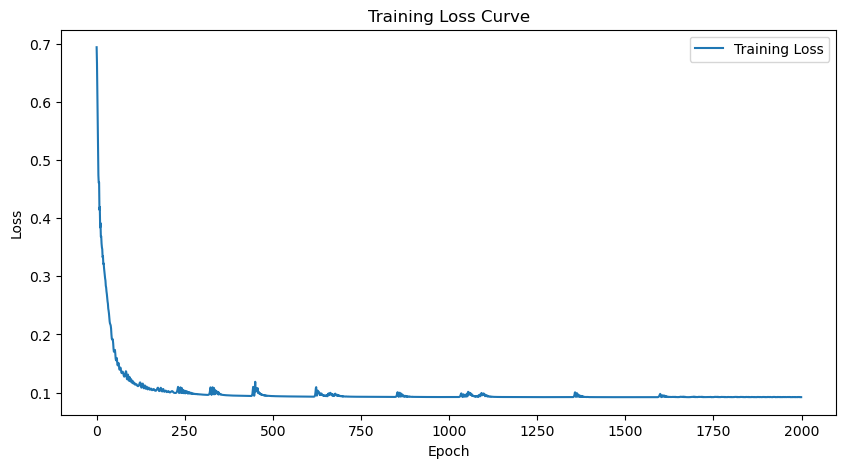

Final Model Accuracy: 78.95%
Final Model F1-score: 0.7906


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 78.95%
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



/tmp/ipykernel_1803985/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
